In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import numbers
import seaborn as sns
import lightgbm as lgb
import numpy as np
from pprint import pprint
import plotly.express as px
import geopandas as gpd
#from geopy.geocoders import Nominatim

In [236]:
import addfips
af = addfips.AddFIPS()
af.get_state_fips('New York')

'36'

## Summary

- Columns that have large correlation with `MIS_Status`
    - `RevLineCr`, `LowDoc`, `Sector`
- Columns that could have some correlation with `MIS_Status`
    - `Term`, `DisbursementDate`, `FranchiseCode` (where 0, 1, or other), `State` and `BankState`, `UrbanRural` and `ApprovalIFY`, `NewExist`

In [237]:
data = pd.read_csv(f"/Users/yuke/Documents/Codes/DSC/DSC_STUDY/FinDataChallenge/takazawa/data/train.csv", index_col=0)

In [238]:
data.shape

(42307, 20)

In [239]:
data.dtypes

Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
MIS_Status             int64
Sector                 int64
ApprovalDate          object
ApprovalFY             int64
City                  object
State                 object
BankState             object
DisbursementGross     object
GrAppv                object
SBA_Appv              object
UrbanRural             int64
dtype: object

In [240]:
data.isnull().sum()

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1079
LowDoc                531
DisbursementDate      150
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              11
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64

In [241]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties["features"][0]

from geopy.geocoders import Nominatim
import ssl
import geopy.geocoders

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

geopy.geocoders.options.default_ssl_context = ctx

def find_county(city, state):
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.geocode(f"{city}, {state}, USA")
    if location:
        # Reverse geocoding to get more details, including county
        location_details = geolocator.reverse([location.latitude, location.longitude], exactly_one=True)
        address = location_details.raw.get('address', {})
        county = address.get('county', 'County not found')
        return county
    else:
        return "Location not found"
import re
def extract_county(location_str):
    # This pattern matches any sequence of characters that ends with " County"
    pattern = r',\s*([a-zA-Z\s]+)\sCounty,'
    
    match = re.search(pattern, location_str)
    
    if match:
        county_name = match.group(1)  # Extract the county name
        return county_name
    else:
        return "County name not found"
def county_FIPS(name, state_name, state_fips):
    a = np.random.choice(["a","b","c"])
    geolocator = Nominatim(user_agent=f"test_{a}") #名前はなんでもOK
    
    print(name, state_name)
    location = geolocator.geocode(f"{name}, {state_name}")
    print(location)
    if location is None:
        return np.nan
    lis = [item for item in counties['features'] if item['properties']['NAME']==location.raw['display_name'] and item['properties']['STATE']==state_fips]
    if len(lis) !=1:
        return np.nan
    print(location)
    return lis[0]['properties']['COUNTY']

In [242]:
import addfips
af = addfips.AddFIPS()

categorical_cols = ['FranchiseCode','RevLineCr', 'LowDoc', 'Sector', 'UrbanRural', 'NewExist']
date_cols = ["DisbursementDate", "ApprovalDate"]
dollar_cols = ["DisbursementGross", "GrAppv", "SBA_Appv"]
for col in categorical_cols:
    data[col] = data[col].astype('category')
    if data[col].isnull().sum():
        data[col] = data[col].cat.add_categories("NAN").fillna("NAN")
for col in date_cols:
    data[col] = pd.to_datetime(data[col], format="%d-%b-%y")
    # add date cols
    data[col + "_year"] = pd.DatetimeIndex(data[col]).year
    data[col + "_month"] = pd.DatetimeIndex(data[col]).month
    data[col + "_day"] = pd.DatetimeIndex(data[col]).day
    data[col + "_daystamp"] = (data[col] - data[col].min()).dt.days
for col in dollar_cols:
    data[col] = data[col].str.replace("[$,]", "", regex=True)
    data[col] = data[col].astype(float)

## I want to run Codes below but currently not possible due to access limit??
# all_states = data['State'].to_numpy()
# all_state_fips = [af.get_state_fips(item) for item in all_states]
# data['State_FIPS'] = all_state_fips
# county_fips = [county_FIPS(item['City'], item['State'], item['State_FIPS']) for i, item in data.iterrows()]
# data['County_FIPS'] = county_fips

In [243]:
data.dtypes

Term                                  int64
NoEmp                                 int64
NewExist                           category
CreateJob                             int64
RetainedJob                           int64
FranchiseCode                      category
RevLineCr                          category
LowDoc                             category
DisbursementDate             datetime64[ns]
MIS_Status                            int64
Sector                             category
ApprovalDate                 datetime64[ns]
ApprovalFY                            int64
City                                 object
State                                object
BankState                            object
DisbursementGross                   float64
GrAppv                              float64
SBA_Appv                            float64
UrbanRural                         category
DisbursementDate_year               float64
DisbursementDate_month              float64
DisbursementDate_day            

In [244]:
def first_plot(label):
    sns.set_style("darkgrid")
    print(data[label].describe())
    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    if data[label].dtype == "category":
        sns.countplot(x=data[label],ax = axes[0])
        proportion_data = data.groupby(label)['MIS_Status'].value_counts(normalize=True).rename('proportion').reset_index()
        #sns.countplot(hue=data[label], x=data['MIS_Status'], ax=axes[1], stat='probability')
        sns.barplot(x=proportion_data['MIS_Status'], y=proportion_data['proportion'], hue=proportion_data[label])
    elif isinstance(data[label].iloc[0], numbers.Number):
        axes[0].hist(data[label], bins=20)
        clf = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=31, learning_rate=0.05, n_estimators=100, lambda_l1=0.5, lambda_l2=0.5, verbose=-1)
        clf.fit(data[[label]], data['MIS_Status'])
        xx = np.linspace(data[label].min(), data[label].max(), 1000)
        y_pred_proba = clf.predict_proba(pd.DataFrame({label: xx}))
        axes[1].plot(xx,y_pred_proba[:,1],label="lgb")
        sns.regplot(x=data[label], ax = axes[1], y=data['MIS_Status'], logistic=True, ci=None, label="logistic", scatter_kws={"alpha":0.1})
        axes[1].legend()
    elif data[label].dtype == "<M8[ns]":
        axes[0].hist(data[label], bins=20)
        clf = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=31, learning_rate=0.05, n_estimators=100, lambda_l1=0.5, lambda_l2=0.5, verbose=-1)
        clf.fit(data[[label+"_daystamp"]], data['MIS_Status'])
        xx = np.linspace(data[label+"_daystamp"].min(), data[label+"_daystamp"].max(), 1000)
        y_pred_proba = clf.predict_proba(pd.DataFrame({label: xx}))
        axes[1].plot(xx,y_pred_proba[:,1],label="lgb")
        sns.regplot(x=data[label+"_daystamp"], ax = axes[1], y=data['MIS_Status'], logistic=True, ci=None, label="logistic", scatter_kws={"alpha":0.1})
        axes[1].legend()
        

## Exploration of each column

### Term
融資の期間（月）, int64

count    42307.000000
mean       108.601673
std         84.569847
min          0.000000
25%         56.000000
50%         82.000000
75%        168.000000
max        360.000000
Name: Term, dtype: float64


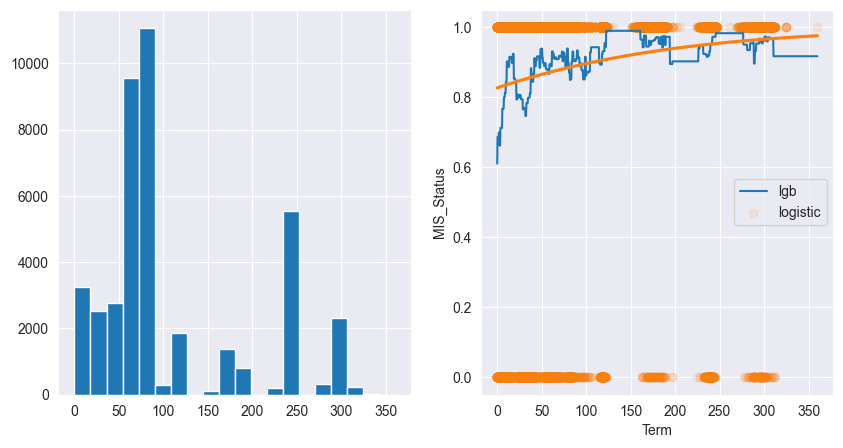

In [245]:
first_plot('Term')

### NoEmp
融資を受ける前の事業の従業員数

count    42307.000000
mean         9.704304
std         17.488022
min          0.000000
25%          2.000000
50%          4.000000
75%         12.000000
max        202.000000
Name: NoEmp, dtype: float64


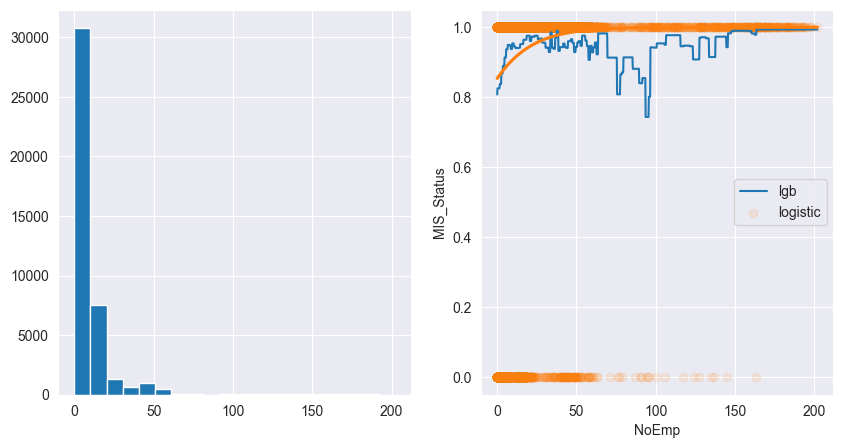

In [246]:
first_plot('NoEmp')

### NewExist
新規ビジネスかどうか
*1 = 既存のビジネス、2 = 新規ビジネス

count     42307.0
unique        2.0
top           1.0
freq      33405.0
Name: NewExist, dtype: float64


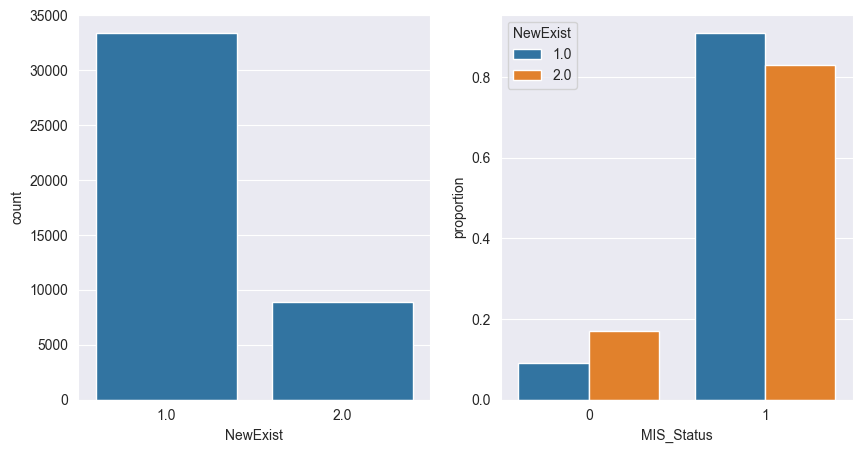

In [247]:
first_plot('NewExist')

### CreateJob
企業が融資資金を使用して創出すると予想される雇用の数

count    42307.000000
mean         2.183728
std          5.093980
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         70.000000
Name: CreateJob, dtype: float64


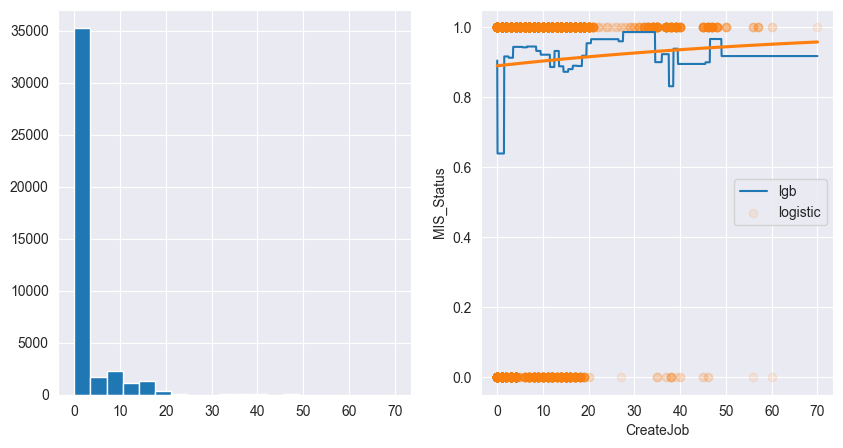

In [213]:
first_plot('CreateJob')

### RetainedJob
融資を受けたことで企業が維持すると予想される雇用の数

count    42307.000000
mean         2.183728
std          5.093980
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         70.000000
Name: CreateJob, dtype: float64


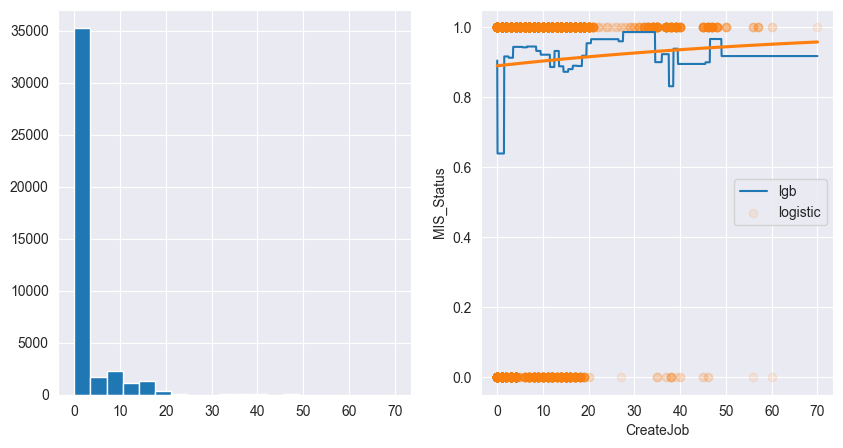

In [214]:
first_plot('CreateJob')

### FranchiseCode
どのブランドのフランチャイズであるかを識別する一意の5桁のコード
*0または1は非フランチャイズを意味する

In [215]:
# 各値のカウント
uniq, counts = np.unique(data['FranchiseCode'], return_counts=True)
code_to_counts = dict(zip(uniq, counts))
print("Counts of Code 1:", code_to_counts[1], ",Counts of Code 0:", code_to_counts[0])
print("Counts - Counts of counts of Franchise codes:")
counts, count_of_counts = np.unique([val for item, val in code_to_counts.items() if item not in [0,1]], return_counts=True)
pprint(dict(zip(counts, count_of_counts)))

Counts of Code 1: 14033 ,Counts of Code 0: 26392
Counts - Counts of counts of Franchise codes:
{1: 23,
 2: 21,
 3: 28,
 4: 18,
 5: 41,
 6: 25,
 7: 17,
 8: 16,
 9: 23,
 10: 18,
 11: 11,
 12: 14,
 13: 4,
 14: 3,
 15: 2,
 18: 2,
 20: 1,
 21: 1,
 182: 1}


Text(0.5, 1.0, 'Franchise')

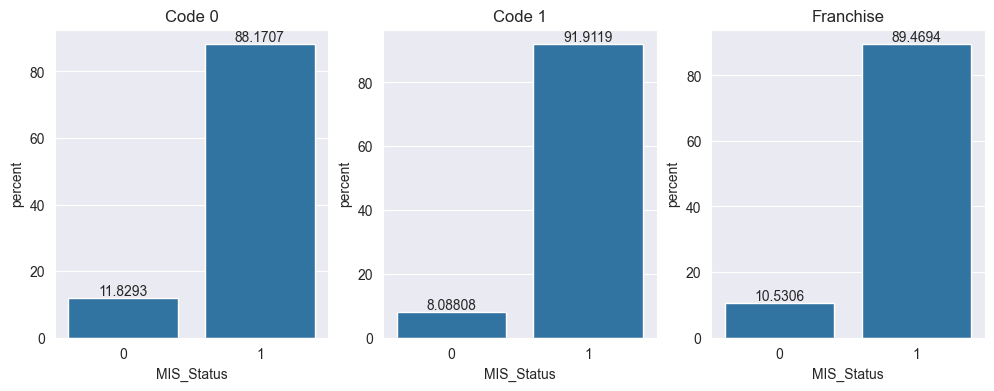

In [216]:
# 各値による影響 (そんなに変わらない...?)
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
sns.countplot(x=data.loc[data['FranchiseCode']==0, "MIS_Status"], stat="percent", ax = axes[0])
axes[0].set_title("Code 0")
axes[0].bar_label(axes[0].containers[0])
sns.countplot(x=data.loc[data['FranchiseCode']==1, "MIS_Status"], stat="percent", ax = axes[1])
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title("Code 1")
sns.countplot(x=data.loc[data['FranchiseCode'].isin([0,1]), "MIS_Status"], stat="percent", ax = axes[2])
axes[2].bar_label(axes[2].containers[0])
axes[2].set_title("Franchise")

### RevLineCr
リボルビング信用枠か
*Y = はい、N = いいえ

count     42307
unique        5
top           N
freq      27618
Name: RevLineCr, dtype: object


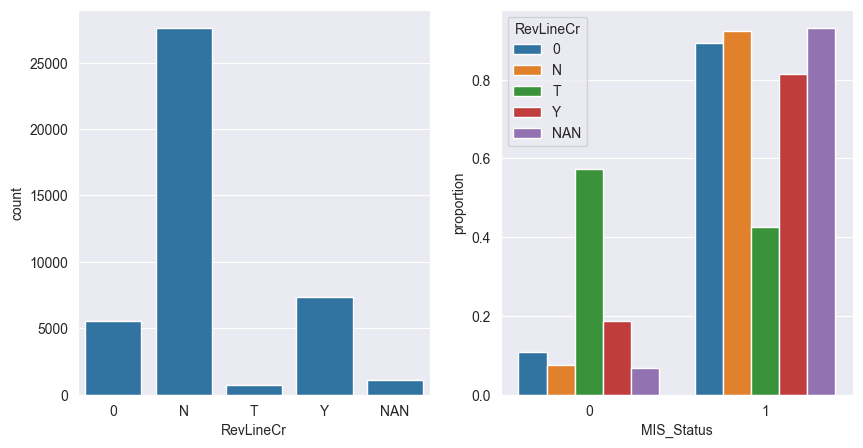

In [217]:
first_plot('RevLineCr')

### LowDoc 
15 万ドル未満のローンを 1 ページの短い申請で処理できるプログラムか
*Y = はい、N = いいえ

count     42307
unique        7
top           N
freq      34313
Name: LowDoc, dtype: object


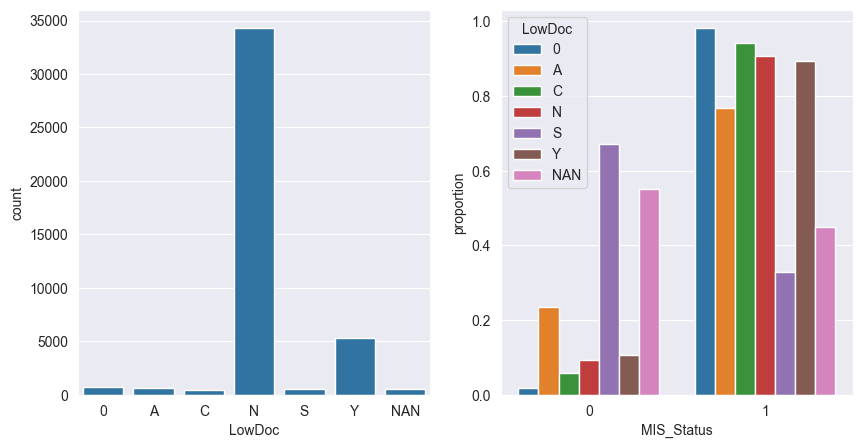

In [218]:
first_plot('LowDoc')

### DisbursementDate
融資の支払日


count                            42157
mean     2001-07-27 17:28:08.345945088
min                1973-12-06 00:00:00
25%                1996-11-16 00:00:00
50%                2002-12-31 00:00:00
75%                2005-12-31 00:00:00
max                2014-07-05 00:00:00
Name: DisbursementDate, dtype: object


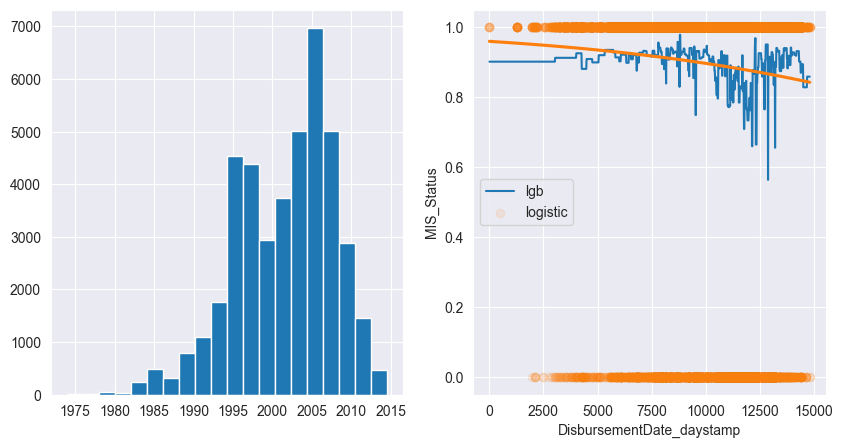

In [219]:
first_plot('DisbursementDate')

### Sector

産業分類コード

count     42307
unique       24
top           0
freq       9798
Name: Sector, dtype: int64


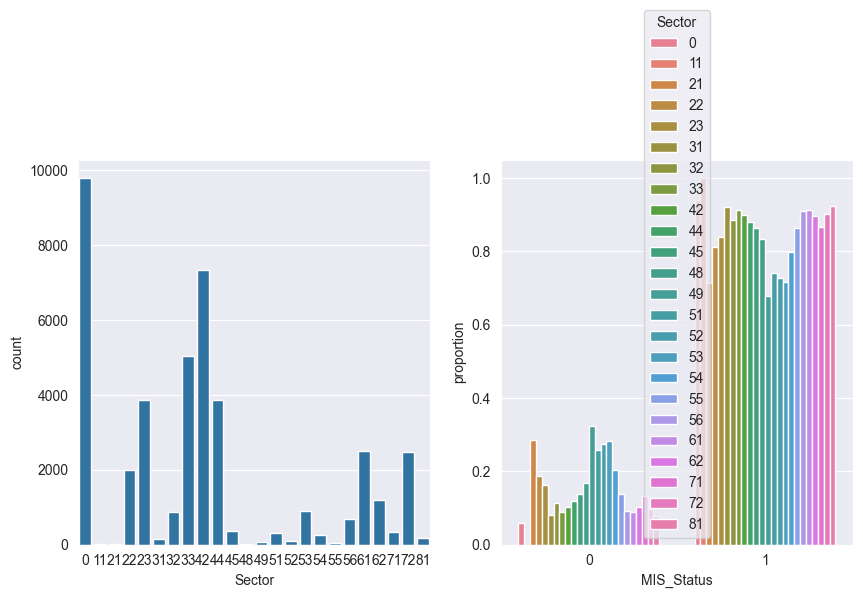

In [220]:
first_plot('Sector')

### ApprovalDate
米国中小企業庁の承認日

count                            42307
mean     2001-10-08 13:59:55.745384832
min                1973-10-17 00:00:00
25%                1997-07-25 00:00:00
50%                2003-04-08 00:00:00
75%                2006-03-30 00:00:00
max                2014-01-13 00:00:00
Name: ApprovalDate, dtype: object


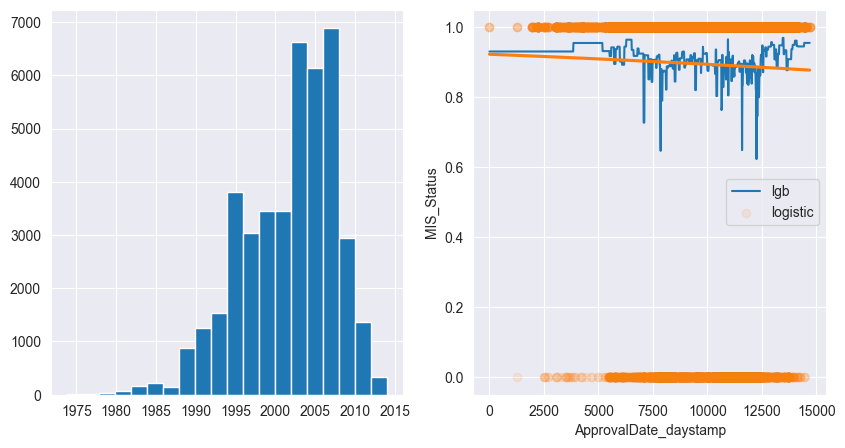

In [221]:
first_plot('ApprovalDate')

### ApprovalFY
承認された財務年度

count    42307.000000
mean      2001.537783
std          5.860527
min       1974.000000
25%       1997.000000
50%       2003.000000
75%       2006.000000
max       2014.000000
Name: ApprovalFY, dtype: float64


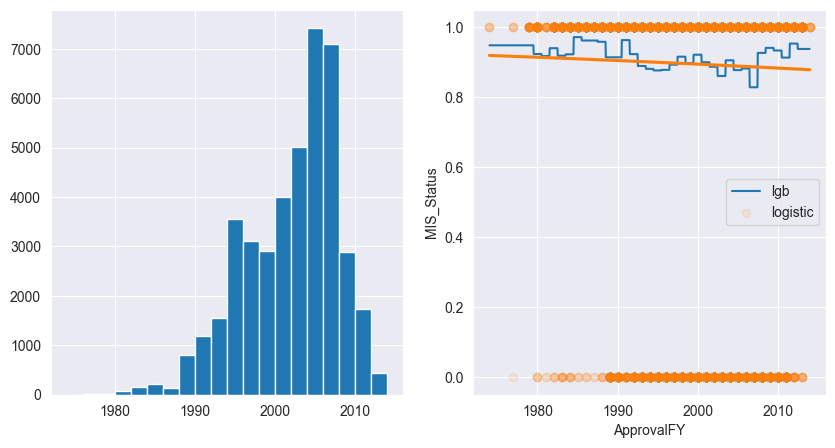

In [222]:
first_plot('ApprovalFY')

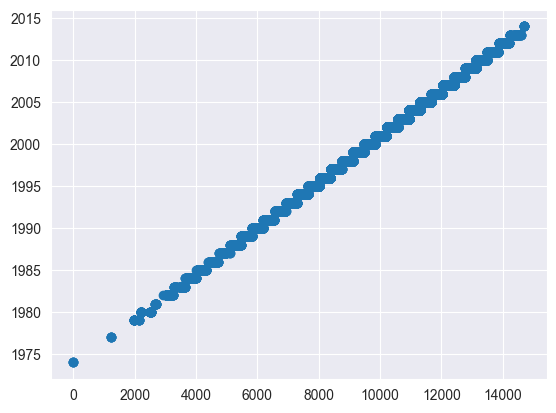

In [223]:
# approval date daystamp 
plt.scatter(data['ApprovalDate_daystamp'], data['ApprovalFY'])

### City, State

In [224]:
fig = px.choropleth(data[["MIS_Status", "State"]].groupby("State").mean().reset_index(),
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='MIS_Status',
                    color_continuous_scale="Viridis_r", 
                    )
fig.show()

In [225]:
fig = px.choropleth(data[["MIS_Status", "State"]].groupby("State").count().reset_index(),
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='MIS_Status',
                    color_continuous_scale="Viridis_r", 
                    )
fig.show()

### BankState
貸し手の所在地（州）

In [226]:
fig = px.choropleth(data[["MIS_Status", "BankState"]].groupby("BankState").mean().reset_index(),
                    locations='BankState', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='MIS_Status',
                    color_continuous_scale="Viridis_r", 
                    )
fig.show()

In [227]:
fig = px.choropleth(data[["MIS_Status", "BankState"]].groupby("BankState").count().reset_index(),
                    locations='BankState', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='MIS_Status',
                    color_continuous_scale="Viridis_r", 
                    )
fig.show()

### DisbursementGross
銀行によって支払われた金額


count    4.230700e+04
mean     1.793574e+05
std      2.487232e+05
min      4.000000e+03
25%      3.900000e+04
50%      9.992200e+04
75%      2.180000e+05
max      6.296554e+06
Name: DisbursementGross, dtype: float64


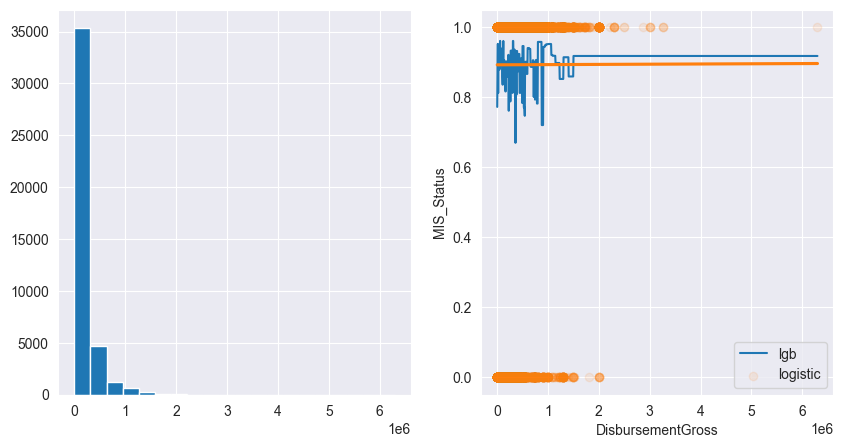

In [228]:
first_plot('DisbursementGross')

### GrAppv
銀行によって承認されたローンの総額

count    4.230700e+04
mean     1.739594e+05
std      2.472657e+05
min      2.000000e+03
25%      3.000000e+04
50%      8.500000e+04
75%      2.025000e+05
max      3.500000e+06
Name: GrAppv, dtype: float64


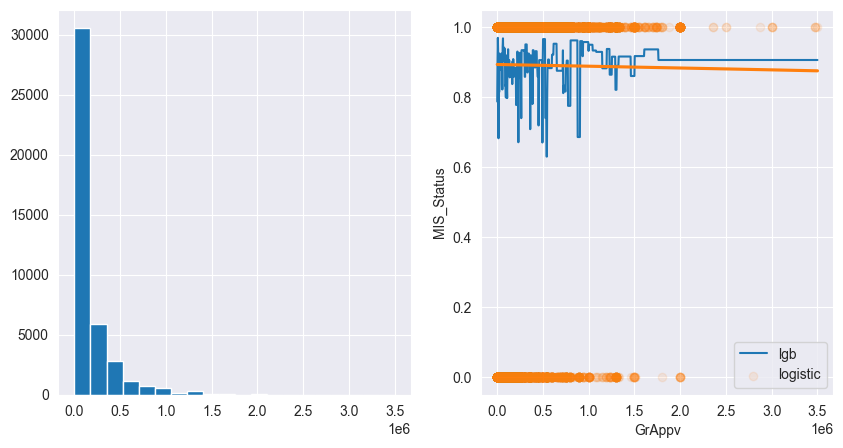

In [229]:
first_plot("GrAppv")

### SBA_Appv
SBAが保証する承認されたローンの金額

count    4.230700e+04
mean     1.376013e+05
std      2.055621e+05
min      1.000000e+03
25%      2.000000e+04
50%      6.400000e+04
75%      1.612500e+05
max      3.471000e+06
Name: SBA_Appv, dtype: float64


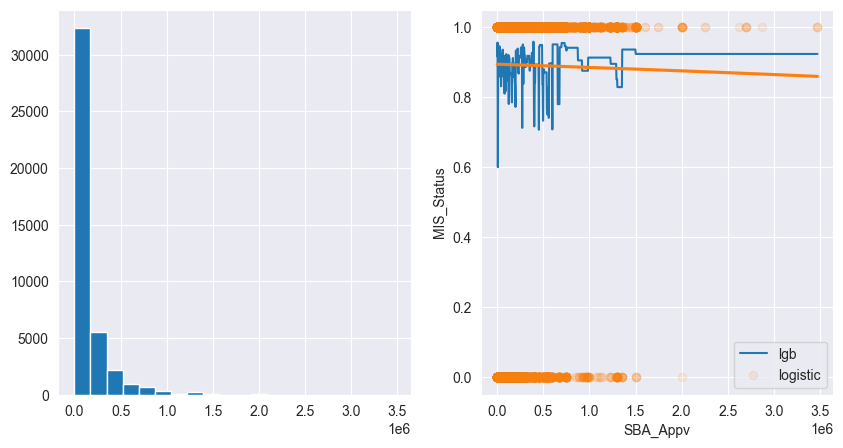

In [230]:
first_plot('SBA_Appv')

### UrbanRural
*1 = 都市部、2 = 田舎、0 = 未定義


count     42307
unique        3
top           0
freq      24037
Name: UrbanRural, dtype: int64


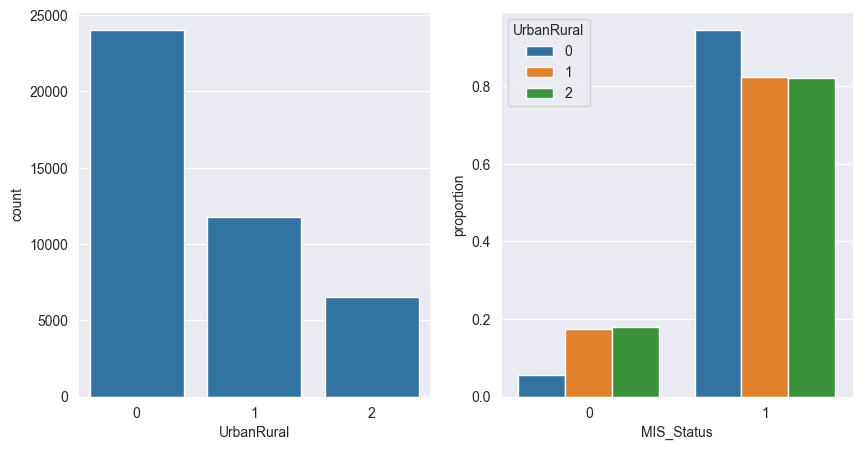

In [231]:
first_plot('UrbanRural')